In [72]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import glob
from PIL import Image
from tqdm import tqdm
import time
import numpy as np
import IPython.display as ipd

from utils.dataloader import CaptchaDataset

# hyperparameter

In [68]:
EPOCHS = 80
CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if CUDA else 'cpu'

# dataloader

In [27]:
image_transform = transforms.Compose([
    # transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

dataset = CaptchaDataset('./Large_Captcha_Dataset', transform=image_transform)

In [28]:
for x, y in dataset:
    print(x.shape)
    print(y)
    break

torch.Size([3, 256, 256])
tensor([ 4, 26, 23, 54,  0])


In [29]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# model

In [55]:
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2)
        self.maxpool3 = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout2d(0.7)
        self.dropout2 = nn.Dropout2d(0.7)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=65536, out_features=512)
        self.linear1 = nn.Linear(in_features=512, out_features=62)
        self.linear2 = nn.Linear(in_features=512, out_features=62)
        self.linear3 = nn.Linear(in_features=512, out_features=62)
        self.linear4 = nn.Linear(in_features=512, out_features=62)
        self.linear5 = nn.Linear(in_features=512, out_features=62)
        self.softmax = nn.Softmax(dim=-1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        
        x = self.dropout1(x)
        x = self.flatten(x)
        
        x = self.linear(x)
        x = self.dropout2(x)
        
        y1 = self.linear1(x)
        y2 = self.linear2(x)
        y3 = self.linear3(x)
        y4 = self.linear4(x)
        y5 = self.linear5(x)
        
        return y1, y2, y3, y4, y5
        
        
#         input_layer = Input((25, 67, 1))
#         x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
#         x = MaxPooling2D(pool_size=(2, 2))(x)

#         x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
#         x = MaxPooling2D(pool_size=(2, 2))(x)

#         x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
#         x = MaxPooling2D(pool_size=(2, 2))(x)

#         x = Dropout(0.3)(x)
#         x = Flatten()(x)
#         x = Dense(512, activation='relu')(x)
#         x = Dropout(0.3)(x)

#         out = [Dense(10, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]

In [56]:
model = myModel()

In [57]:
if CUDA:
    model = model.cuda()

# train

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [59]:
loss_history = []

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


26/80, 80.56 sec/epoch
current loss=15.8718


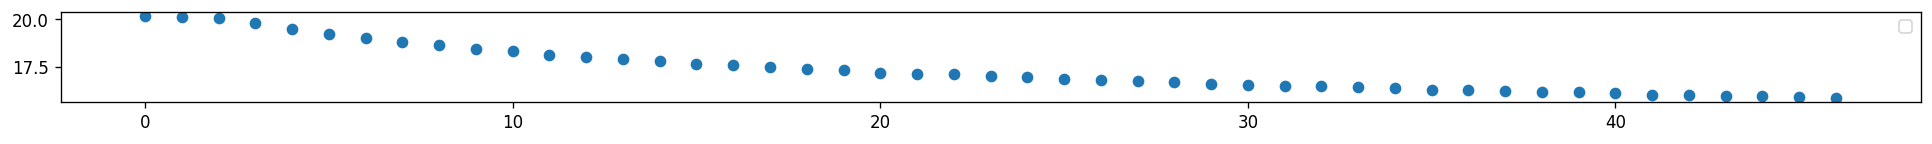

 49%|███████████████████▋                    | 506/1030 [00:40<00:42, 12.35it/s]


KeyboardInterrupt: 

In [69]:
for e in range(EPOCHS):
    start_time = time.time()
    current_loss = []
    for (x, y) in tqdm(train_dataloader):
        optimizer.zero_grad()
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]
        
        pred1, pred2, pred3, pred4, pred5 = model(x)

        loss1 = criterion(pred1, y1)
        loss2 = criterion(pred2, y2)
        loss3 = criterion(pred3, y3)
        loss4 = criterion(pred4, y4)
        loss5 = criterion(pred5, y5)
        loss = loss1 + loss2 + loss3 + loss4 + loss5
        current_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    current_loss = np.mean(current_loss).item()
    loss_history.append(current_loss)
    
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
    print(f"current loss={current_loss:.4f}")
    plt.figure(figsize=(20,1),dpi=120)
    plt.scatter(np.arange(len(loss_history)), loss_history)
    plt.legend(loc=1)
    plt.show()

In [37]:
_input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = criterion(_input, target)

In [38]:
_input.shape

torch.Size([3, 5])

In [39]:
target.shape

torch.Size([3])